In [29]:
import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy import interpolate, integrate
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Add custom library path (update this path as needed)
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [30]:
# Constants
FRAME_RATE = 30   # frames per second
TIME_WINDOW_SEC = 20
MIN_DURATION_FRAMES = TIME_WINDOW_SEC * FRAME_RATE

In [31]:
# Data folder path
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'

Local Average Calculator

In [32]:
def local_average_calculator(trace, window_sec=TIME_WINDOW_SEC):
    """
    Compute the mean of the first `window_sec` seconds of a trace.
    """
    n_points = int(window_sec * FRAME_RATE)
    return np.mean(trace[:n_points]) if len(trace) >= n_points else np.mean(trace)

Local Median Calculator

In [33]:
# def local_average_calculator(trace, window_sec=TIME_WINDOW_SEC):
#     """
#     Calculate the local median of the first `window_sec` seconds of a trace.
#     """
#     n_points = int(window_sec * FRAME_RATE)
#     if len(trace) >= n_points:
#         return np.median(trace[:n_points])
#     else:
#         return np.median(trace)


Data Loading and Grouping

In [34]:
def load_experiments_from_folder(folder):
    experiments = []
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            path = os.path.join(folder, filename)
            with open(path, 'rb') as f:
                experiments.append(pickle.load(f))
            print(f"Loaded: {filename}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments


def get_sapap_genotype(genotype_string):
    tag = "Sapap("
    if tag in genotype_string:
        start = genotype_string.find(tag) + len(tag)
        end = genotype_string.find(")", start)
        return genotype_string[start:end]
    return None


def group_experiments_by_genotype(experiments):
    wt, ko = [], []
    for exp in experiments:
        genotype = get_sapap_genotype(exp.Genotype)
        if genotype == "WT":
            wt.append(exp)
        elif genotype == "KO":
            ko.append(exp)
        else:
            print(f"Warning: Unknown Sapap genotype for {exp.Mouse_id}")
    print(f"Number of WT mice: {len(wt)} | KO mice: {len(ko)}")
    return wt, ko


Bout Extraction & Z-score Retrieval

In [35]:
def get_non_grooming_bouts(experiment, min_duration_frames=None):
    """
    Return list of (start_frame, end_frame) for non-grooming periods.
    If min_duration_frames is provided, only include bouts >= that length.
    """
    total = len(experiment.GCaMP_data.time)
    annotations = experiment.Grooming_annotations or []
    if not annotations:
        bouts = [(0, total - 1)]
    else:
        groom_frames = set(f for s, e in annotations for f in range(s, e + 1))
        non_frames = [f for f in range(total) if f not in groom_frames]
        bouts = []
        if non_frames:
            start = non_frames[0]
            for i in range(1, len(non_frames)):
                if non_frames[i] != non_frames[i - 1] + 1:
                    bouts.append((start, non_frames[i - 1]))
                    start = non_frames[i]
            bouts.append((start, non_frames[-1]))
    if min_duration_frames:
        bouts = [(s, e) for s, e in bouts if (e - s + 1) >= min_duration_frames]
    return bouts


def get_gcamp_z_score_for_bouts(experiment, min_duration_frames=MIN_DURATION_FRAMES):
    """
    Retrieve Z-score traces and times for non-grooming bouts
    of at least min_duration_frames.
    """
    results = []
    for s, e in get_non_grooming_bouts(experiment, min_duration_frames):
        z, t = experiment.get_gcamp_data_Z_score(s, e)
        results.append((z, t))
    return results


def find_shortest_bout(group, min_duration_frames=MIN_DURATION_FRAMES):
    """
    Return the duration (sec) of the shortest non-grooming bout >= min_duration_frames.
    """
    shortest = float('inf')
    for exp in group:
        bouts = get_non_grooming_bouts(exp, min_duration_frames)
        if bouts:
            shortest = min(shortest, min(e - s + 1 for s, e in bouts))
    return (shortest / FRAME_RATE) if shortest < float('inf') else None


def compute_individual_mouse_averages(group, min_duration_sec, min_duration_frames=MIN_DURATION_FRAMES):
    """
    For each mouse, compute its mean trace across bouts,
    baseline-corrected by its own local average.
    Returns list of 1D arrays (one per mouse).
    """
    n_pts = int(min_duration_sec * FRAME_RATE)
    indiv = []
    for exp in group:
        bouts = get_gcamp_z_score_for_bouts(exp, min_duration_frames)
        traces = [z[:n_pts] for z, _ in bouts if len(z) >= n_pts]
        if not traces:
            continue
        mouse_mean = np.mean(traces, axis=0)
        baseline = local_average_calculator(mouse_mean, min_duration_sec)
        indiv.append(mouse_mean - baseline)
    return indiv


def compute_group_stats_from_individuals(individual_means, min_duration_sec):
    """
    Given a list of baseline-corrected individual traces,
    compute group time array, mean, std, and SEM.
    """
    if not individual_means:
        return None
    arr = np.stack(individual_means, axis=0)
    mean_trace = np.mean(arr, axis=0)
    std_trace = np.std(arr, axis=0)
    sem_trace = std_trace / np.sqrt(arr.shape[0])
    time_array = np.linspace(0, min_duration_sec, num=arr.shape[1])
    return time_array, mean_trace, std_trace, sem_trace


Plotting

In [36]:
def plot_avg_trace_with_sem(time_array, mean_z, sem_z, group_name, color, num_bouts,
                            individual_traces=None):
    plt.figure(figsize=(10,5))
    if individual_traces:
        for trace in individual_traces:
            plt.plot(time_array, trace, color='grey', alpha=0.5)
    plt.plot(time_array, mean_z, label=f"{group_name} Mean (n={num_bouts} bouts)", color=color)
    plt.fill_between(time_array, mean_z-sem_z, mean_z+sem_z, color=color, alpha=0.3)
    plt.axhline(0, color='k', linestyle='--')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('GCaMP ΔF (Z-score)')
    plt.title(f"{group_name} Trace (Mean ± SEM)")
    plt.legend()
    plt.show()


def plot_combined_avg_trace(time_array,
                            wt_mean, wt_sem, wt_bouts,
                            ko_mean, ko_sem, ko_bouts,
                            wt_color='blue', ko_color='red'):
    plt.figure(figsize=(10,5))
    plt.plot(time_array, wt_mean, label=f"WT Mean (n={wt_bouts} bouts)", color=wt_color)
    plt.fill_between(time_array, wt_mean-wt_sem, wt_mean+wt_sem, color=wt_color, alpha=0.3)
    plt.plot(time_array, ko_mean, label=f"KO Mean (n={ko_bouts} bouts)", color=ko_color)
    plt.fill_between(time_array, ko_mean-ko_sem, ko_mean+ko_sem, color=ko_color, alpha=0.3)
    plt.axhline(0, color='k', linestyle='--')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('GCaMP ΔF (Z-score)')
    plt.title('WT vs KO (Mean ± SEM)')
    plt.legend()
    plt.show()

Main funtion

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 15
Number of WT mice: 7 | KO mice: 8


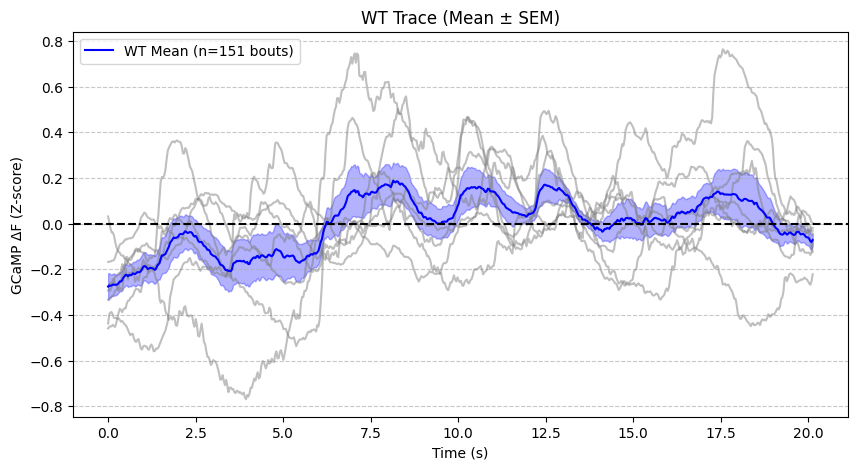

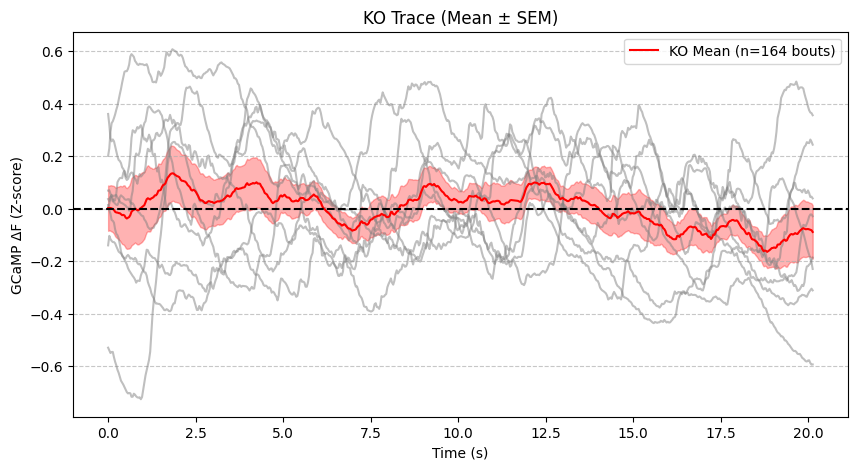

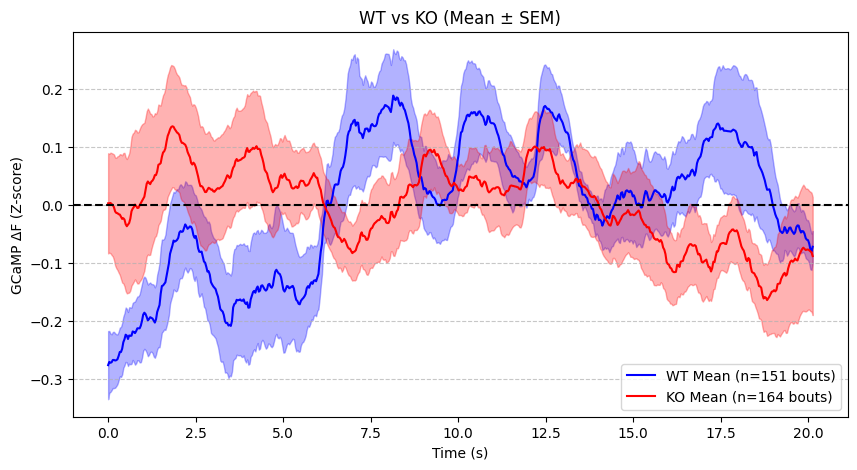

In [37]:
def main():
    # Load and group experiments
    experiments = load_experiments_from_folder(DATA_FOLDER)
    wt_group, ko_group = group_experiments_by_genotype(experiments)

    # Determine common duration for averaging
    shortest_wt = find_shortest_bout(wt_group)
    shortest_ko = find_shortest_bout(ko_group)
    durations = [d for d in (shortest_wt, shortest_ko) if d]
    common_dur = min(durations) if durations else TIME_WINDOW_SEC

    # Compute baseline-corrected individual means
    indiv_wt = compute_individual_mouse_averages(wt_group, common_dur)
    indiv_ko = compute_individual_mouse_averages(ko_group, common_dur)

    # Count total bouts per group
    wt_bout_count = sum(len(get_non_grooming_bouts(exp, MIN_DURATION_FRAMES)) for exp in wt_group)
    ko_bout_count = sum(len(get_non_grooming_bouts(exp, MIN_DURATION_FRAMES)) for exp in ko_group)

    # Compute group stats
    wt_stats = compute_group_stats_from_individuals(indiv_wt, common_dur)
    ko_stats = compute_group_stats_from_individuals(indiv_ko, common_dur)

    # Plot WT
    if wt_stats:
        t_arr, wt_mean, wt_std, wt_sem = wt_stats
        plot_avg_trace_with_sem(
            t_arr, wt_mean, wt_sem,
            'WT', 'blue',
            wt_bout_count,
            individual_traces=indiv_wt
        )

    # Plot KO
    if ko_stats:
        _, ko_mean, ko_std, ko_sem = ko_stats
        plot_avg_trace_with_sem(
            t_arr, ko_mean, ko_sem,
            'KO', 'red',
            ko_bout_count,
            individual_traces=indiv_ko
        )

    # Combined plot
    if wt_stats and ko_stats:
        plot_combined_avg_trace(
            t_arr,
            wt_mean, wt_sem, wt_bout_count,
            ko_mean, ko_sem, ko_bout_count
        )

if __name__ == '__main__':
    main()